# Laguerre tessellations and polycrystalline microstructures: a fast algorithm for generating grains of given volumes

This Python notebook includes some examples from the following paper:

* Bourne, D.P., Kok, P.J.J., Roper, S.M. & Spanjer, W.D.T. (2020) Laguerre tessellations and polycrystalline microstructures: A fast algorithm for generating grains of given volumes, Philosophical Magazine, 100, 2677-2707. [PDF here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053)

We use the optimal transport library [pysdot](https://github.com/sd-ot/pysdot) and the visualisation library [vtk](https://pypi.org/project/vtk/). The library pysdot implements the damped Newton algorithm from [here](https://arxiv.org/abs/1603.05579).

In [1]:
#@title If running in Google Colab, install pysdot, vtk and PyVista

RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !pip install pysdot > install_pysdot.log
    !pip install vtk > install_vtk.log
    !apt-get install -q xvfb libgl1-mesa-glx &>/dev/null
    !pip install pyvista > install_pyvista.log

In [2]:
#@title Import libraries

import numpy as np

from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import OptimalTransport
from pysdot import PowerDiagram

import itertools

import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from vtk.util.numpy_support import vtk_to_numpy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm, colors

import pyvista as pv
pv.global_theme.notebook = True
if RunningInCOLAB:
    pv.global_theme.jupyter_backend = 'static'
    pv.global_theme.notebook = True
    pv.start_xvfb()

## Algorithm 1

The following function implements Algorithm 1 from this paper:

* Bourne, D.P., Kok, P.J.J., Roper, S.M. & Spanjer, W.D.T. (2020) Laguerre tessellations and polycrystalline microstructures: A fast algorithm for generating grains of given volumes, Philosophical Magazine, 100, 2677-2707. [PDF here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053)

In [3]:
#@title Algorithm 1
def algorithm1(bx,X,target_vols,periodic=None,w0=None,tol=1):

    """ This function implements Algorithm 1 from the following paper:

    Bourne, D.P., Kok, P.J.J., Roper, S.M. & Spanjer, W.D.T. (2020)
    Laguerre tessellations and polycrystalline microstructures:
    A fast algorithm for generating grains of given volumes,
    Philosophical Magazine, 100, 2677-2707.
    https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053

    Parameters
    ----------

    bx : ndarray, shape (d,2)
        minimum and maximum coordinates of the box in each of the d dimensions
        (d=2,3)
    X : ndarray, shape (N,d)
        locations of the N seeds
    target_vols: ndarray, shape (N,)
        target volumes of the N Laguerre cells
    periodic: list, optional, length d
        list of Booleans indicating whether or not the domain is periodic in
        the different directions. None indicates no periodicity in any direction
    w0 : ndarray, optional, shape (N,)
        initial guess for the weights for Algorithm 1.
        None indicates that the weights should be zero
    tol : float, optional
        relative percentage error for volumes

    Returns
    -------

    ot : OptimalTransport object
        This contains the weights of the Laguerre tessellation with cells of
        volumes target_vols (up to tolerance tol)

    """

    # Get the dimension of the box (d=2 or d=3)
    d = np.shape(bx)[0]

    # If periodic = None, then no periodicity
    if periodic is not None:
        len_periodic = len(periodic)
        if len_periodic != d:
            print('The periodicity list should be length equal to the dimension of the box')
            return

    # Build the domain
    omega = ConvexPolyhedraAssembly()

    mins = bx[:,0].copy()
    maxs = bx[:,1].copy()
    lens = bx[:,1]-bx[:,0]
    if periodic is not None:
        for k,p in enumerate(periodic):
            if p:
                mins[k] = mins[k]-lens[k]
                maxs[k] = maxs[k]+lens[k]
    omega.add_box(mins,maxs)

    # Turn the relative percentage error into an absolute error tolerance
    # by using the smallest volume
    err_tol = np.min(target_vols)*tol/100.

    # If w0 is None, then set the initial guess to zero
    if w0 is None:
        N = np.shape(X)[0]
        w0 = np.zeros(N)

    # Set up the optimal transport problem
    ot = OptimalTransport(positions = X, masses = target_vols, weights = w0,
                          domain = omega, obj_max_dm = err_tol, verbosity = 0)

    # If there is periodicity, then add the replicants
    if periodic is not None:

        periodic_dict = {True:[-1,0,1],False:[0]}
        periodic_list = [periodic_dict[p] for p in periodic]

        cartesian_periodic = list(itertools.product(*periodic_list))

        for rep in cartesian_periodic:
            if rep != (0,0,0):
                ot.pd.add_replication(rep*lens)

    # Solve the optimal transport problem (solve for the weights)
    ot.adjust_weights()

    return ot

## Algorithm 2

The following function implements Algorithm 2 from this paper:

* Bourne, D.P., Kok, P.J.J., Roper, S.M. & Spanjer, W.D.T. (2020) Laguerre tessellations and polycrystalline microstructures: A fast algorithm for generating grains of given volumes, Philosophical Magazine, 100, 2677-2707. [PDF here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053)

In [4]:
#@title Algorithm 2
def algorithm2(bx,X,target_vols,periodic=None,tol=1,numLloyd=1):

    """This function implements Algorithm 2 from the following paper:

    Bourne, D.P., Kok, P.J.J., Roper, S.M. & Spanjer, W.D.T. (2020)
    Laguerre tessellations and polycrystalline microstructures:
    A fast algorithm for generating grains of given volumes,
    Philosophical Magazine, 100, 2677-2707.
    https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053

    Parameters
    ----------

    bx : ndarray, shape (d,2)
        minimum and maximum coordinates of the box in each of the d dimensions
        (d=2,3)
    X : ndarray, shape (N,d)
        initial locations of the N seeds
    target_vols: ndarray, shape (N,)
        target volumes of the N Laguerre cells
    periodic: list, optional, length d
        list of Booleans indicating whether or not the domain is periodic in
        the different directions. None indicates no periodicity in any direction
    tol : float, optional
        relative percentage error for volumes
    numLloyd : int, optional
        number of iterations of Lloyd's algorithm (move each seed to the
        centroid of its cell)

    Returns
    -------

    ot : OptimalTransport object
        This contains the weights and seeds of a Laguerre tessellation with
        cells of volumes target_vols (up to tolerance tol). The seed locations
        are computed using Lloyd's algorithm.

    """

    # Get the dimension of the box (d=2 or d=3)
    d = np.shape(bx)[0]

    # If periodic = None, then no periodicity
    if periodic is not None:
        len_periodic = len(periodic)
        if len_periodic != d:
            print('The periodicity list should be length equal to the dimension of the box')
            return

    # Build the domain
    omega = ConvexPolyhedraAssembly()

    mins=bx[:,0].copy()
    maxs=bx[:,1].copy()
    lens=bx[:,1]-bx[:,0]
    if periodic is not None:
        for k,p in enumerate(periodic):
            if p:
                mins[k] = mins[k]-lens[k]
                maxs[k] = maxs[k]+lens[k]
    omega.add_box(mins,maxs)

    # Turn the relative percentage error into an absolute error tolerance
    # by using the smallest volume
    err_tol = np.min(target_vols)*tol/100.

    # Set the initial weights to zero
    N = X.shape[0]
    w0 = np.zeros(N)

    # Set up the transport problem
    ot = OptimalTransport(positions = X, masses = target_vols, weights = w0,
                          domain = omega, obj_max_dm = err_tol, verbosity = 0)

    # If there is periodicity, then add the replicants
    if periodic is not None:

        periodic_dict = {True:[-1,0,1],False:[0]}
        periodic_list = [periodic_dict[p] for p in periodic]

        cartesian_periodic = list(itertools.product(*periodic_list))

        for rep in cartesian_periodic:
            if rep != (0,0,0):
                ot.pd.add_replication(rep*lens)

    # Algorithm 2
    for k in range(numLloyd):

        # Calculate the centroids
        xbar = ot.get_centroids()

        # Update the seed positions
        ot.set_positions(xbar)

        # Solve the optimal transport problem.
        # If moving the seeds and maintaining the weights gives a cell that is
        # empty, then we have a bad initial guess for the OT solver.
        # Check whether the smallest volume is bigger than some tolerance:
        # if so, then use the same weights; if not, reset the weights to zero.
        m = ot.pd.integrals()
        if np.min(m) > 1e-10:
            # Solve for the weights
            ot.adjust_weights()
        else:
            print('Resetting weights to zero')
            ot.set_weights(w0)
            # Solve for the weights
            ot.adjust_weights()

    return ot

## Plotting functions

Functions for plotting Laguerre tessellations (power diagrams) in 2D and 3D.

In [5]:
#@title Plotting functions

# Plot 2D Laguerre tessellations
def plot_cells2d(ot,ax=None,titlestr=None,colorby=None):

    filename = "tmp.vtk"
    ot.pd.display_vtk(filename)

    if ax is None:
        fig, ax = plt.subplots()

    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    data=reader.GetOutput()

    N = data.GetNumberOfCells()

    numpy_array_of_cells = dsa.WrapDataObject(data).Cells
    numpy_array_of_points = dsa.WrapDataObject(data).Points
    cells = vtk_to_numpy(numpy_array_of_cells)
    verts = vtk_to_numpy(numpy_array_of_points)

    if colorby is not None:

        cmap = cm.coolwarm
        norm = mcolors.Normalize(vmin=np.min(colorby), vmax=np.max(colorby))
        colors = cmap(norm(colorby))

        idx = 0
        for k in range(N):
            nv = cells[idx]
            vidx = cells[idx+1:idx+nv+1]
            idx = idx+nv+1
            im = ax.fill(verts[vidx,0],verts[vidx,1],color=colors[k],linewidth=1)

    idx = 0
    for k in range(N):
        nv = cells[idx]
        vidx = cells[idx+1:idx+nv+1]
        idx = idx+nv+1
        ax.plot(verts[vidx,0],verts[vidx,1],'k',linewidth=1)
    ax.set_title(titlestr)

# Plot 3D Laguerre tessellations
def plot_cells3d(ot,ax=None,titlestr=None,colorby=None,box=None):

    filename = "tmp.vtk"
    ot.pd.display_vtk(filename)

    # Store the volumes in an array
    if colorby is None:
        colorby = ot.pd.integrals()

    # Read the data
    otgrid = pv.read(filename)

    ## Specify the colours
    # create cell data that gives the cell volumes, this allows us to colour by cell volumes
    otcell_col = colorby[otgrid.cell_data['num'].astype(int)]
    otgrid.cell_data['vols']=otcell_col

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    #grid.plot(scalars='vols',jupyter_backend='static',background='white')
    otplotter = pv.Plotter(window_size=[800,800],notebook=True)

    if box is not None:
        bx = box.reshape(6).tolist()
        otplotter.add_mesh(otgrid,show_edges=True)
    else:
        otplotter.add_mesh(otgrid,show_edges=True)

    otplotter.show()

    # Add a headlight
    light = pv.Light(light_type='headlight')
    otplotter.add_light(light)

## Experiments

We perform some quick experiments to test the code.

First we use Algorithm 2 to generate a 2D periodic Laguerre tessellation in the unit square with 1000 grains of equal area, up to 0.01% error.

Resetting weights to zero


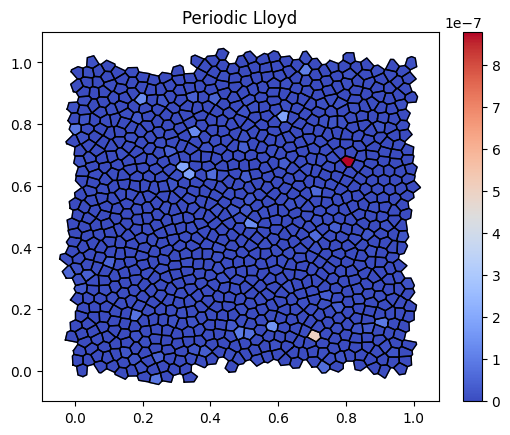

In [6]:
# Set up the box
box2d = np.array([[0,1],[0,1]])

# Number of grains
N = 1000

# Random initial seed locations
X = np.random.rand(N,2)@np.diag(box2d[:,1]-box2d[:,0])+box2d[:,0]

# Target areas of the Laguerre cells (all cells equal area)
target_areas = np.ones(N);
target_areas = np.prod(box2d[:,1]-box2d[:,0])*target_areas/np.sum(target_areas)

# Use Algorithm 2 to find a Laguerre tessellation with grains of the target areas
ot2 = algorithm2(box2d,X,target_areas,periodic=[True,True],tol=1e-2,numLloyd=10)

# Plot the Laguerre tessellation. Each cell is coloured according to the
# percentage error of its area.
fig, ax = plt.subplots()
area_error = np.abs(ot2.pd.integrals()-target_areas)/target_areas*100
plot_cells2d(ot2,ax=ax,titlestr="Periodic Lloyd",colorby=area_error)
norm = colors.Normalize(np.min(area_error), np.max(area_error))
cmap = cm.coolwarm
fig.colorbar(cm.ScalarMappable(norm=norm,cmap=cmap),ax=ax)

Now we use Algorithm 2 to generate a 3D non-periodic Laguerre tessellation in a rectangular box with 100 grains of random volumes, up to 0.01% error.

Resetting weights to zero


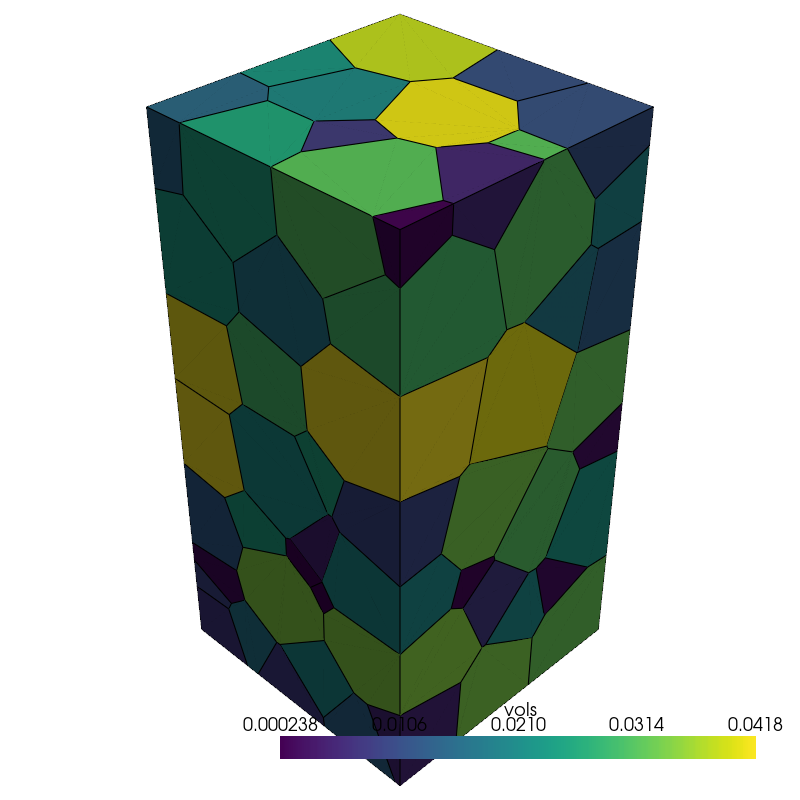

In [7]:
# Set up the box
box1 = np.array([[0,1],[0,1],[1,3]])

# Number of grains
N = 100

# Random initial seed locations
X=np.random.rand(N,3)@np.diag(box1[:,1]-box1[:,0])+box1[:,0]

# Target areas of the Laguerre cells (random volumes)
target_vols = np.random.rand(N);
target_vols = np.prod(box1[:,1]-box1[:,0])*target_vols/np.sum(target_vols)

# Use Algorithm 2 to find a Laguerre tessellation with grains of the target volumes
ot1 = algorithm2(box1,X,target_vols,periodic=[False,False,False],tol=1e-2,numLloyd=10)

# Plot the Laguerre tessellation. Each cell is coloured according to its volume
plot_cells3d(ot1,ax=None,titlestr="Periodic Lloyd",colorby=target_vols,box=box1)

## Examples from the paper

In the section we give some examples from the following paper:

* Bourne, D.P., Kok, P.J.J., Roper, S.M. & Spanjer, W.D.T. (2020) Laguerre tessellations and polycrystalline microstructures: A fast algorithm for generating grains of given volumes, Philosophical Magazine, 100, 2677-2707. [PDF here](https://www.tandfonline.com/doi/full/10.1080/14786435.2020.1790053)

### Example 5.1

Set up the size and periodicity of the box, the target volumes, and the parameters for Algorithm 2:

In [8]:
# Define the box size
L1 = 100
L2 = 100
L3 = 100

# Define the box
box51 = np.array([[0,L1],[0,L2],[0,L3]])
box51_vol = np.prod(box51[:,1]-box51[:,0])

# Set the periodicity in the three directions
periodic51 = None # no periodicity
#periodic51 = [True,True,True] # periodic in every direction

# Set the number of grains for the run-time tests
numGrains = [1000,2000,3000,5000,7500,10000,15000,20000]

# Set the parameters for Algorithm 2
numLloyd = 5
percent_tol = 1

Run time tests for the idealised single phase (SP) microstructures (all grains equal volume):

In [9]:
import time
runtimes_SP = [0]*len(numGrains)

for k,N in enumerate(numGrains):
    print(f"Calculating run times for n={N}")

    # Random seed locations
    X = np.random.rand(N,3)@np.diag(box51[:,1]-box51[:,0])+box51[:,0]
    target_vols = np.ones(N)*box51_vol/N

    start = time.time()
    ot51 = algorithm2(box51,X,target_vols,periodic=periodic51,tol=percent_tol,numLloyd=numLloyd)
    end = time.time()

    percent_error = 100.*np.abs(ot51.pd.integrals()-target_vols)/target_vols
    max_percent_error = np.max(percent_error)

    duration = end-start
    print(f" : completed in {duration} seconds")
    print(f" : max percentage error = {max_percent_error}")

    runtimes_SP[k] = duration

print(runtimes_SP)

Calculating run times for n=1000
 : completed in 3.258558750152588 seconds
 : max percentage error = 0.07788525803807715
Calculating run times for n=2000
 : completed in 4.582505464553833 seconds
 : max percentage error = 0.10529559154949766
Calculating run times for n=3000
 : completed in 5.120605707168579 seconds
 : max percentage error = 0.09156940357359532
Calculating run times for n=5000
 : completed in 11.484935522079468 seconds
 : max percentage error = 0.09123885376214957
Calculating run times for n=7500
 : completed in 21.17663860321045 seconds
 : max percentage error = 0.0929730142805667
Calculating run times for n=10000
 : completed in 33.304975271224976 seconds
 : max percentage error = 0.10806363980964306
Calculating run times for n=15000
 : completed in 85.9285831451416 seconds
 : max percentage error = 0.1306645075527797
Calculating run times for n=20000
 : completed in 146.13193011283875 seconds
 : max percentage error = 0.17783248279124564
[3.258558750152588, 4.5825054

Plot the Laguerre tessellation that was computed during the final run time test:

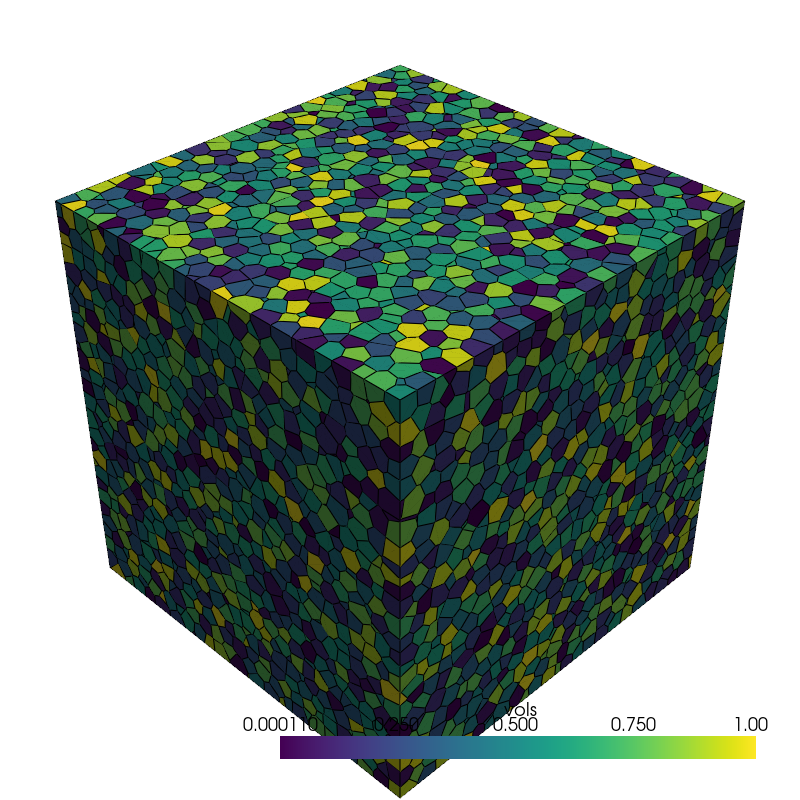

In [10]:
plot_cells3d(ot51,ax=None,titlestr="Periodic Lloyd : Single Phase",colorby=np.random.rand(numGrains[-1]))

Run time tests for the idealised dual phase (DP) microstructures ($N/2$ grains of volume $v$, $N/2$ grains of volume $5v$):

In [11]:
# Function to compute the volumes of the grains in an idealised dual phase
# microstructure with n1 grains of volume v and n2 grains of volume r*v,
# where v is chosen so that the total volume of the grains equals 1.
def DP_vols(n1,n2,r=1):
    vols = np.hstack((np.ones(n1),r*np.ones(n2)))
    vols = vols/np.sum(vols)
    return vols

In [12]:
import time
runtimes_DP = [0]*len(numGrains)

# Dual phase volume ratio
r = 5

for k,N in enumerate(numGrains):
    print(f"Calculating run times for n={N}")

    # Random seed locations
    X = np.random.rand(N,3)@np.diag(box51[:,1]-box51[:,0])+box51[:,0]
    target_vols = box51_vol*DP_vols(N//2,N//2,r)

    start = time.time()
    ot51 = algorithm2(box51,X,target_vols,periodic=periodic51,tol=percent_tol,numLloyd=numLloyd)
    end = time.time()

    percent_error = 100.*np.abs(ot51.pd.integrals()-target_vols)/target_vols
    max_percent_error = np.max(percent_error)

    duration = end-start
    print(f" : completed in {duration} seconds")
    print(f" : max percentage error = {max_percent_error}")

    runtimes_DP[k] = duration

print(runtimes_DP)

Calculating run times for n=1000
Resetting weights to zero
 : completed in 1.9095616340637207 seconds
 : max percentage error = 0.01537213816349663
Calculating run times for n=2000
Resetting weights to zero
 : completed in 2.5748586654663086 seconds
 : max percentage error = 0.014032911933202287
Calculating run times for n=3000
Resetting weights to zero
 : completed in 4.997059106826782 seconds
 : max percentage error = 0.011625498395503087
Calculating run times for n=5000
Resetting weights to zero
 : completed in 11.858346462249756 seconds
 : max percentage error = 0.025619983981655988
Calculating run times for n=7500
Resetting weights to zero
 : completed in 24.108585119247437 seconds
 : max percentage error = 0.015181531401241342
Calculating run times for n=10000
Resetting weights to zero
 : completed in 42.51196837425232 seconds
 : max percentage error = 0.026953095087428377
Calculating run times for n=15000
Resetting weights to zero
 : completed in 96.42846441268921 seconds
 : max

Plot the Laguerre tessellation that was computed during the final run time test:

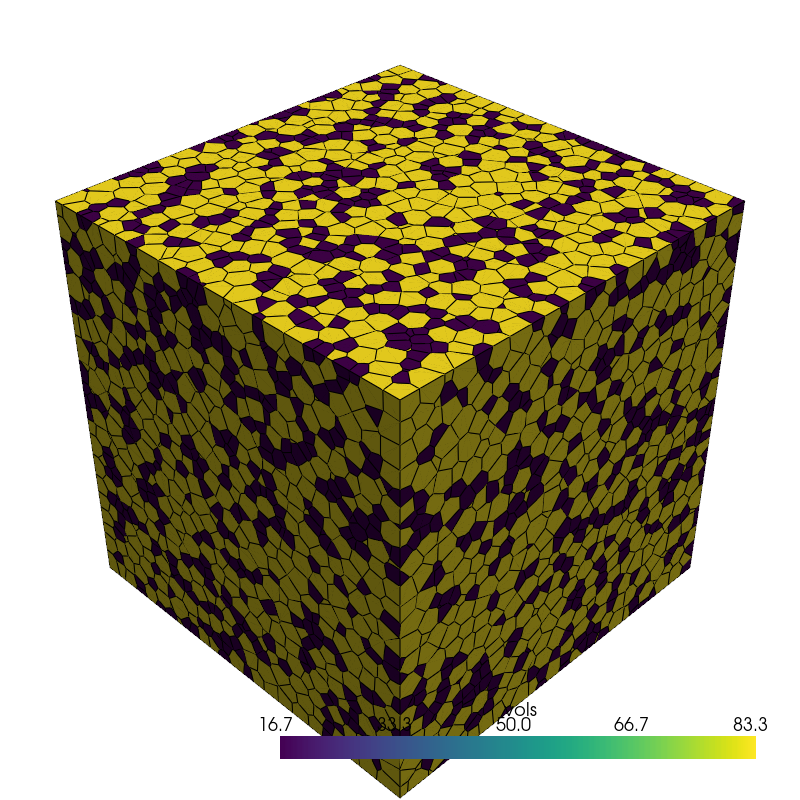

In [13]:
plot_cells3d(ot51,ax=None,titlestr="Periodic Lloyd : Dual Phase",colorby=target_vols)

Plot the run times:

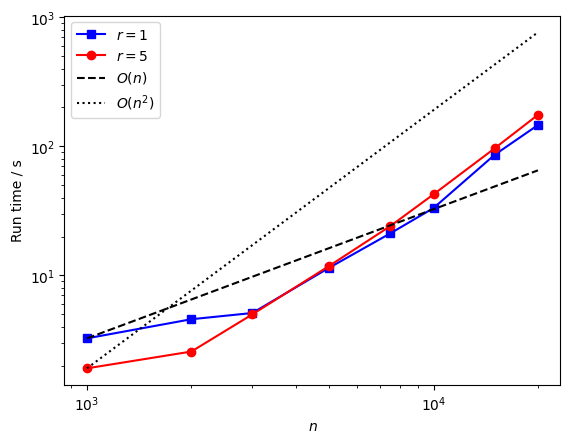

In [14]:
fig,ax=plt.subplots()
ax.loglog(numGrains,runtimes_SP,'bs-',label='$r=1$')
ax.loglog(numGrains,runtimes_DP,'ro-',label='$r=5$')

# Add O(n) curve to the plot
c=np.exp(np.log(runtimes_SP[0])-np.log(numGrains[0]));
ax.loglog(numGrains,c*np.array(numGrains),'k--',label='$O(n)$')

## Add O(n^2) curve to the plot
c=np.exp(np.log(runtimes_DP[0])-2*np.log(numGrains[0]));
ax.loglog(numGrains,c*np.array(numGrains)**2,'k',linestyle='dotted',label='$O(n^2)$')

ax.set_xlabel('$n$')
ax.set_ylabel('Run time / s')
ax.legend()

### Example 5.4

In this example we generate a dual phase RVE with a banded microstructure.

First we define some helper functions for computing the target volumes and for plotting:

In [15]:
# Function to compute the volumes of the grains in each layer
def layered(nlayer,rlayer,dim=3):

    nlayer = np.array(nlayer)
    rlayer = np.array(rlayer)

    # Number of grains
    N = np.sum(nlayer)

    # Relative volumes of the grains (relative to the volume of the box)
    rel_vols = np.repeat(rlayer,nlayer)
    total = np.sum(nlayer*rlayer)
    rel_vols = rel_vols/total

    # Thickness of each layer
    tlayer = nlayer*rlayer/total
    olayer = np.cumsum(tlayer)
    olayer = np.hstack(([0],olayer[0:-1]))

    # Locations of the seeds within the layers
    Xl = []
    for k,n in enumerate(nlayer):
        Xl.append(olayer[k]+tlayer[k]*np.random.rand(n,1))

    Z = np.concatenate(Xl)
    X = np.hstack((np.random.rand(N,dim-1),Z))

    return X, rel_vols

# Function to plot the errors in the volumes of the grains
def ploterrors(errordata,ax=None):

    cdx = np.sort(errordata)
    cdy = np.array(range(np.size(cdx),0,-1))
    if ax is None:
        f, ax = plt.subplots()
    ax.loglog(cdx,cdy)
    ax.set_xlabel(r'Percentage error')
    ax.set_ylabel(r'Number of grains')

Set up the size and periodicity of the box, the number of layers, the target volumes, and the parameters for Algorithm 2:

In [16]:
# Define box size
L1 = 2
L2 = 3
L3 = 2

# Define box
box54 = np.array([[0,L1],[0,L2],[0,L3]])
box54_vol = np.prod(box54[:,1]-box54[:,0])

# Set periodicity in the three directions
periodic54 = None
#periodic54 = [True]*3

# Number of grains
nLayer = [1000,8000,1000]
rLayer = [1,0.05,1]

# Target volumes and initial seed locations
X, rel_vols = layered(nLayer,rLayer)
X = X@np.diag([L1,L2,L3])
target_vols = rel_vols*box54_vol

# Set parameters for algorithm 2
numLloyd = 20
percent_tol = 1

Perform Algorithm 2:

In [17]:
import time
start = time.time()
ot54 = algorithm2(box54,X,target_vols,periodic=periodic54,tol=percent_tol,numLloyd=numLloyd)
end = time.time()
print(f'Run time = {end-start} seconds')

Resetting weights to zero
Run time = 96.7493634223938 seconds


Plot the results:

Maximum percentage error is 0.3138364865001679%


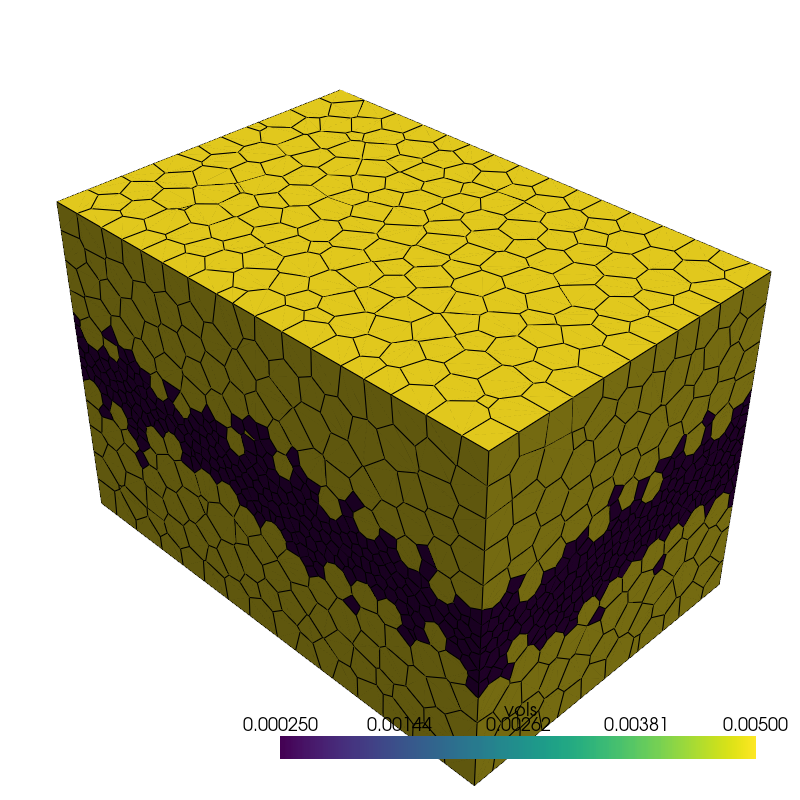

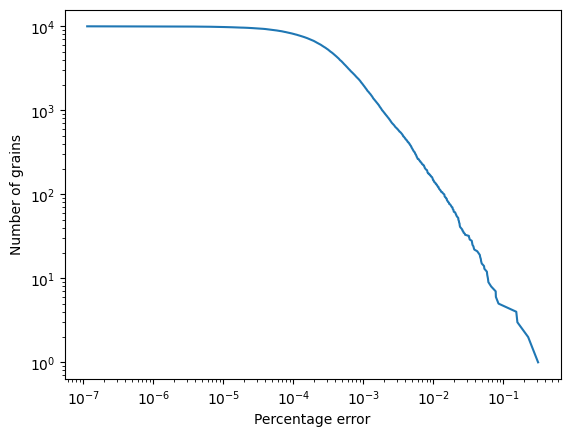

In [18]:
percentage_errors = 100.*np.abs(ot54.pd.integrals()-target_vols)/target_vols
print(f'Maximum percentage error is {np.max(percentage_errors)}%')
ploterrors(percentage_errors,ax=None)
plot_cells3d(ot54,ax=None,titlestr="Periodic Lloyd : Layered",colorby=target_vols)